<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [Feature Engineering](05.04-Feature-Engineering.ipynb) | [Contents](Index.ipynb) | [In Depth: Linear Regression](05.06-Linear-Regression.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.05-Naive-Bayes.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# In Depth: Naive Bayes Classification

The previous four sections have given a general overview of the concepts of machine learning.
In this section and the ones that follow, we will be taking a closer look at several specific algorithms for supervised and unsupervised learning, starting here with naive Bayes classification.

Naive Bayes models are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets.
Because they are so fast and have so few tunable parameters, they end up being very useful as a quick-and-dirty baseline for a classification problem.
This section will focus on an intuitive explanation of how naive Bayes classifiers work, followed by a couple examples of them in action on some datasets.

## Bayesian Classification

Naive Bayes classifiers are built on Bayesian classification methods.
These rely on Bayes's theorem, which is an equation describing the relationship of conditional probabilities of statistical quantities.
In Bayesian classification, we're interested in finding the probability of a label given some observed features, which we can write as $P(L~|~{\rm features})$.
Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

$$
P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})}
$$

If we are trying to decide between two labels—let's call them $L_1$ and $L_2$—then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

$$
\frac{P(L_1~|~{\rm features})}{P(L_2~|~{\rm features})} = \frac{P({\rm features}~|~L_1)}{P({\rm features}~|~L_2)}\frac{P(L_1)}{P(L_2)}
$$

All we need now is some model by which we can compute $P({\rm features}~|~L_i)$ for each label.
Such a model is called a *generative model* because it specifies the hypothetical random process that generates the data.
Specifying this generative model for each label is the main piece of the training of such a Bayesian classifier.
The general version of such a training step is a very difficult task, but we can make it simpler through the use of some simplifying assumptions about the form of this model.

This is where the "naive" in "naive Bayes" comes in: if we make very naive assumptions about the generative model for each label, we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification.
Different types of naive Bayes classifiers rest on different naive assumptions about the data, and we will examine a few of these in the following sections.

We begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Gaussian Naive Bayes

Perhaps the easiest naive Bayes classifier to understand is Gaussian naive Bayes.
In this classifier, the assumption is that *data from each label is drawn from a simple Gaussian distribution*.
Imagine that you have the following data:

## Multinomial Naive Bayes

The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each label.
Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple multinomial distribution.
The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive Bayes is most appropriate for features that represent counts or count rates.

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model the data distribuiton with a best-fit multinomial distribution.

### Example: Classifying Text

One place where multinomial naive Bayes is often used is in text classification, where the features are related to word counts or frequencies within the documents to be classified.
We discussed the extraction of such features from text in [Feature Engineering](05.04-Feature-Engineering.ipynb); here we will use the sparse word count features from the 20 Newsgroups corpus to show how we might classify these short documents into categories.

Let's download the data and take a look at the target names:

In [2]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

For simplicity here, we will select just a few of these categories, and download the training and testing set:

In [3]:
categories = ['talk.religion.misc', 'sci.space', 'rec.motorcycles']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [4]:
# Creation of Vocabulary
vocab = ['Religion','God', 'Beliefs','Religious','Believers','Christ','Church','Orthodox','Muslim','Bible','Truth','Morals','Scripture','Commandments','Christian','Politics','Culture','Sin','Interpret','Mormon','prayer'] \
+ ['star', 'sun', 'sonic', 'titan', 'jupyter', 'planets', 'astronomy', 'astronomer', 'moon', 'nasa', 'earth', 'astronomical', 'space', 'spacecraft', 'planetary', 'universe', 'supersonic', 'satelite', 'orbit'] \
+ ['speed','bike','BMW','BMWRA','helmet','manufacturer','fiberglass','low-speed']

In [5]:
vocab = [ v.lower() for v in vocab]
len(vocab)

48

In [6]:
train.target_names

['rec.motorcycles', 'sci.space', 'talk.religion.misc']

In [7]:
# collect data strings only for 'space'
data_space = []
for i in range(len(train.data)):
    if train.target_names[train.target[i]] == "sci.space":
        # print (i, train.target_names[train.target[i]])
        data_space.append(train.data[i])
#
# print(data_space[2])
len(data_space)

593

In [8]:
# let's count!
# vocabcount_space = np.zeros( (len(vocab)), dtype='int')
vocabcount_space = { v: 0 for v in vocab}

total_w = 0
for dstr in data_space:
    words = dstr.lower().split()
    # print(words)
    for w in words:
        if w in vocab:
            # print(w)
            total_w += 1
            vocabcount_space[w] += 1
#
print(f"total words in vocab = {total_w}") 

total = 0
for k, v in vocabcount_space.items():
    total += v 
print(total)


total words in vocab = 2508
2508


In [9]:
# Add 1 to every count = Laplace Smoothing
for k in vocabcount_space:
    vocabcount_space[k] += 1 

total = 0
for k, v in vocabcount_space.items():
    total += v 
print("total after lapace smoothing: ", total)

# convert counts to prob
for k in vocabcount_space:
    vocabcount_space[k] /= total

total after lapace smoothing:  2556


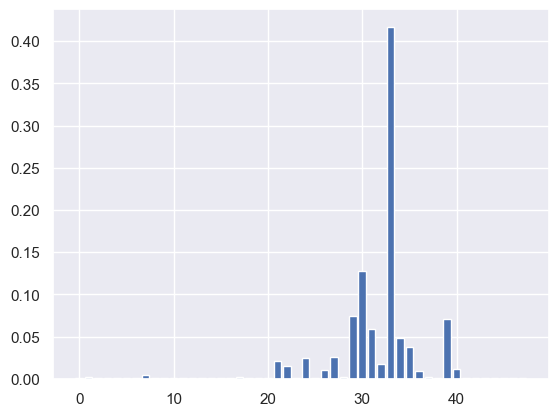

In [10]:
plt.bar(np.arange(len(vocabcount_space.values())), vocabcount_space.values());

In [11]:
# compute log-probability

vocab_space_logp = { key: np.log(value) for key, value in vocabcount_space.items() }

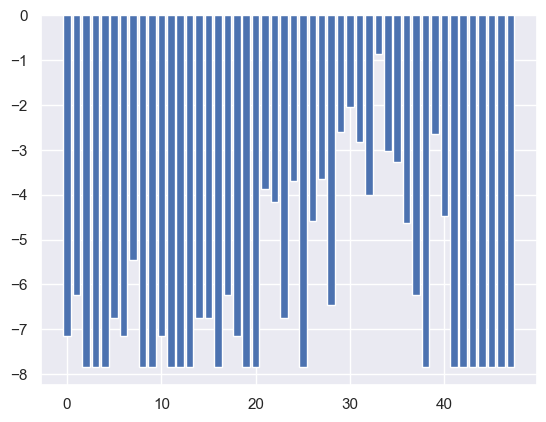

In [12]:
plt.bar(np.arange(len(vocabcount_space.values())), vocab_space_logp.values());

In [13]:
tsample = test.data[0]
print(test.target_names[test.target[0]], '\n+++\n', tsample[3], '\n+++\n')

space_logp = 0 
for w in tsample.lower().split():
    if w in vocab:
        print(w)
        space_logp += vocab_space_logp[w]
#
print('total space_logp = ', space_logp)

rec.motorcycles 
+++
 m 
+++

bike
total space_logp =  -7.846198815497425


Here is a representative entry from the data:

End.